# Comparison of TFIDF and word2vec .

### By- Kanav Malik

In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline


We are going to evaluate the two word embeddings first with a relatively small data set then with the data set of relatively larger corpus. 


In [2]:
import json

lst_dics = []
with open('data_news.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
    
lst_dics[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

In [3]:
df = pd.DataFrame(lst_dics)
df = df[ df["category"].isin(['ENTERTAINMENT','POLITICS','TECH']) ][["category","headline"]]
df = df.rename(columns={"headline":"post" ,"category":"tags"})

In [4]:
df.sample(5)

,tags,post
40708,POLITICS,Americans Dislike How The Media Treats Trump -...
65015,POLITICS,Jan Brewer Criticizes Mitt Romney's Attack On ...
9575,ENTERTAINMENT,"Yes, George Clooney Once Gifted His 14 Closest..."
80599,POLITICS,Mothers Who Lost Sons In The Iraq War Lobby Fo...
95601,ENTERTAINMENT,Taylor Swift Reportedly Bought A Porn Site Dom...


let's take a look at our distribution of categories in the above data set.

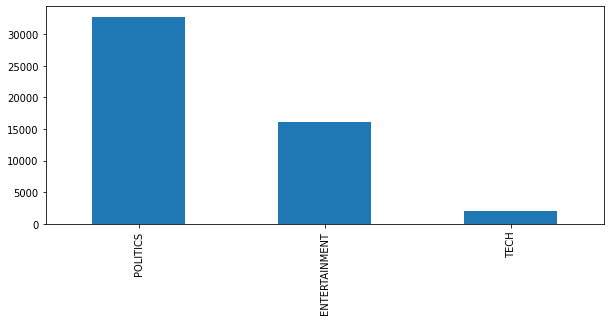

In [5]:
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

In [6]:
def print_plot(index):
    postValue = df[df.index == index][['post', 'tags']].values[0]
    if len(postValue) > 0:
        print(postValue[0])
        print('Tag:', postValue[1])

In [7]:
print_plot(5)

Morgan Freeman 'Devastated' That Sexual Harassment Claims Could Undermine Legacy
Tag: ENTERTAINMENT


Performing cleanup of text: 

In [8]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
#     print('text', text)
#     text = BeautifulSoup(text, "lxml").text # HTML decoding
#     text = BeautifulSoup(text,  "html.parser")
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [9]:
df['post'] = df['post'].apply(clean_text)

In [10]:
print_plot(5)

morgan freeman devastated sexual harassment claims could undermine legacy
Tag: ENTERTAINMENT


In [50]:
df['post'].apply(lambda x: len(x.split(' '))).sum()


378393

As we can se above we have around 300k words to work with for our comparison.

Let's first understand what is TF-IDF?

## TF-IDF

## Term Frequency (TF)

The number of times a word appears in a document divded by the total number of words in the document. Every document has its own term frequency.

<img src="tf.png">

## Inverse Data Frequency (IDF)

The log of the number of documents divided by the number of documents that contain the word w. Inverse data frequency determines the weight of rare words across all documents in the corpus.

<img src="idf.png">

Finally, the TF-IDF is simply the TF multiplied by IDF.

<img src="tfidf.png">

In the next steps, We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers.

In [11]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

accuracy 0.9001572327044025
               precision    recall  f1-score   support

ENTERTAINMENT       0.95      0.83      0.89      4905
     POLITICS       0.88      0.99      0.93      9759
         TECH       1.00      0.07      0.12       600

     accuracy                           0.90     15264
    macro avg       0.94      0.63      0.65     15264
 weighted avg       0.91      0.90      0.88     15264

[0.95, 0.83, 0.89]
[0.88, 0.99, 0.93]
[1.0, 0.07, 0.12]


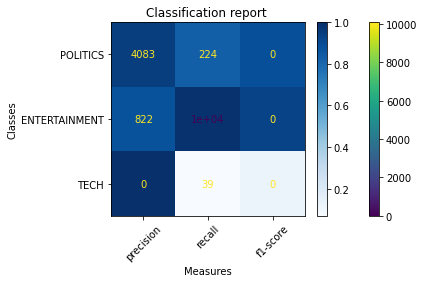

CPU times: user 1.46 s, sys: 105 ms, total: 1.56 s
Wall time: 1.37 s


In [13]:
%%time
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

# for plotting report
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:   
        #print(line)    
        t = line.split()      
        # print(t)    
        if(len(t)==0):         
            break
#     for line in lines[2 : (len(lines) - 3)]:
#         #print(line)
#         t = line.split()
#         # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')


plot_confusion_matrix(nb,y_test, y_pred)  
target_names = ['POLITICS','ENTERTAINMENT','TECH']
classificationReport = classification_report(y_test, y_pred, target_names=target_names)

plot_classification_report(classificationReport)
# plot_classification_report(sampleClassificationReport)

plt.show()  

we achieved 90% accuracy for the above case

## Word2Vec

word2vec algorithm was developed by milkov and here we can se below the two parts of word2vec: 

1.Skip-gram Word2Vec:
Skip-gram Word2Vec is an architecture for computing word embeddings. Instead of using surrounding words to predict the center word, as with CBow Word2Vec, Skip-gram Word2Vec uses the central word to predict the surrounding words.

The skip-gram objective function sums the log probabilities of the surrounding  words to the left and right of the target word  to produce the following objective:

<img src="skipw2vec.png">

2.Continuous Bag-of-Words Word2Vec is an architecture for creating word embeddings that uses  future words as well as  past words to create a word embedding. The objective function for CBOW is:

<img src="cboww2vec.png">

In [14]:
%%time
from gensim.models import Word2Vec

wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)


CPU times: user 36.1 s, sys: 2.9 s, total: 39 s
Wall time: 39 s


In [15]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

The common way is to average the two word vectors.we are using BOW based approaches which includes averaging.

In [16]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

tokenising the words

In [17]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [18]:
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

In [19]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

<ipython-input-16-664dfaa6d69c>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


using logistic regression

In [20]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['tags'])
y_pred = logreg.predict(X_test_word_average)

/home/kanav/informationRetrivalSytem/word2vec/jupyterenviornment/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.9061844863731656
               precision    recall  f1-score   support

ENTERTAINMENT       0.89      0.86      0.88      4905
     POLITICS       0.92      0.95      0.93      9759
         TECH       0.73      0.61      0.67       600

     accuracy                           0.91     15264
    macro avg       0.85      0.81      0.83     15264
 weighted avg       0.90      0.91      0.90     15264

[0.89, 0.86, 0.88]
[0.92, 0.95, 0.93]
[0.73, 0.61, 0.67]


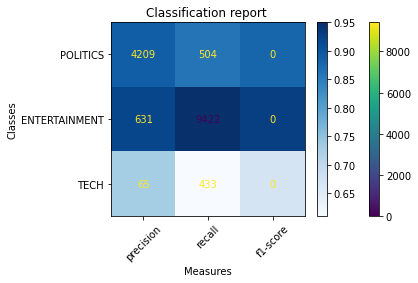

In [23]:
print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred))

# for plotting report
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:   
        #print(line)    
        t = line.split()      
        # print(t)    
        if(len(t)==0):         
            break
#     for line in lines[2 : (len(lines) - 3)]:
#         #print(line)
#         t = line.split()
#         # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')


plot_confusion_matrix(nb,y_test, y_pred)  
target_names = ['POLITICS','ENTERTAINMENT','TECH']
classificationReport = classification_report(y_test, y_pred, target_names=target_names)

plot_classification_report(classificationReport)
# plot_classification_report(sampleClassificationReport)

plt.show()  

we achieved 90.6% accuracy for the above case

as with this set of corpus we can see both the cases are almost equal and any one can be used for a small data set of words around 300k

#### we are now going to perfom the same functions as done above, Now our corpus is significantly bigger for comparison.

In [27]:
df2 = pd.read_csv('stack-overflow-data.csv')
df2 = df2[pd.notnull(df2['tags'])]
df2.head(10)

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python
5,how to give alias name for my website i have ...,asp.net
6,window.open() returns null in angularjs it wo...,angularjs
7,identifying server timeout quickly in iphone ...,iphone
8,unknown method key error in rails 2.3.8 unit ...,ruby-on-rails
9,from the include how to show and hide the con...,angularjs


In [28]:
df2['post'].apply(lambda x: len(x.split(' '))).sum()


10286120

as we can see above we have more than 10 million words in the data

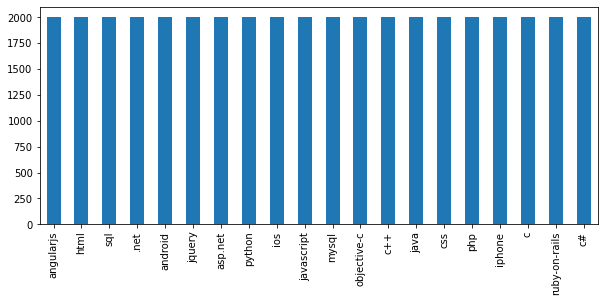

In [30]:
my_tags = ['java','html','asp.net','c#','ruby-on-rails','jquery','mysql','php','ios','javascript','python','c','css','android','iphone','sql','objective-c','c++','angularjs','.net']
plt.figure(figsize=(10,4))
df2.tags.value_counts().plot(kind='bar');

As we can see above this is a balanced data set, as classes are balanced.

In [31]:
def print_plot(index):
    example = df2[df2.index == index][['post', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

In [32]:
print_plot(10)

when we need interface c# <blockquote>    <strong>possible duplicate:</strong><br>   <a href= https://stackoverflow.com/questions/240152/why-would-i-want-to-use-interfaces >why would i want to use interfaces </a>   <a href= https://stackoverflow.com/questions/9451868/why-i-need-interface >why i need interface </a>    </blockquote>     i want to know where and when to use it     for example    <pre><code>interface idemo {  // function prototype  public void show(); }  // first class using the interface class myclass1 : idemo {  public void show()  {   // function body comes here   response.write( i m in myclass );  }  }  // second class using the interface class myclass2 : idemo {  public void show()   {   // function body comes here   response.write( i m in myclass2 );   response.write( so  what  );  } </code></pre>   these two classes has the same function name with different body. this can be even achieved without interface. then why we need an interface where and when to use it
Tag:

In [33]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [34]:
df2['post'] = df2['post'].apply(clean_text)

after cleaning the text:

In [35]:
print_plot(10)

need interface c# possible duplicate would want use interfaces need interface want know use example interface idemo function prototype public void show first class using interface class myclass1 idemo public void show function body comes responsewrite myclass second class using interface class myclass2 idemo public void show function body comes responsewrite myclass2 responsewrite two classes function name different body even achieved without interface need interface use
Tag: c#


In [37]:
df2['post'].apply(lambda x: len(x.split(' '))).sum()

3424060

after cleaning text, we have around 3 million words to work with.


In [38]:
X = df2.post
y = df2.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

## TF-IDF on second data set

In [39]:
nb2 = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb2.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

accuracy 0.7393333333333333
               precision    recall  f1-score   support

         java       0.63      0.65      0.64       613
         html       0.94      0.86      0.90       620
      asp.net       0.87      0.92      0.90       587
           c#       0.70      0.77      0.73       586
ruby-on-rails       0.73      0.87      0.79       599
       jquery       0.72      0.51      0.60       589
        mysql       0.77      0.74      0.75       594
          php       0.69      0.89      0.78       610
          ios       0.63      0.59      0.61       617
   javascript       0.57      0.65      0.60       587
       python       0.70      0.50      0.59       611
            c       0.79      0.78      0.79       594
          css       0.84      0.59      0.69       619
      android       0.65      0.84      0.74       574
       iphone       0.64      0.83      0.72       584
          sql       0.66      0.64      0.65       578
  objective-c       0.79      0.77  

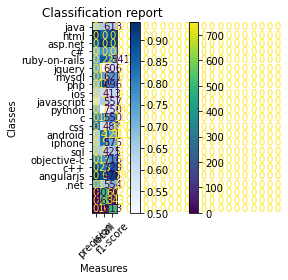

In [41]:
y_pred = nb2.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

# for plotting report
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:   
        #print(line)    
        t = line.split()      
        # print(t)    
        if(len(t)==0):         
            break
#     for line in lines[2 : (len(lines) - 3)]:
#         #print(line)
#         t = line.split()
#         # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')


plot_confusion_matrix(nb,y_test, y_pred)  
target_names = ['java','html','asp.net','c#','ruby-on-rails','jquery','mysql','php','ios','javascript','python','c','css','android','iphone','sql','objective-c','c++','angularjs','.net']

classificationReport = classification_report(y_test, y_pred, target_names=target_names)

plot_classification_report(classificationReport)
# plot_classification_report(sampleClassificationReport)

plt.show()  

## Word2Vec

In [42]:
list(islice(wv.vocab, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

In [43]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [44]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [45]:
train, test = train_test_split(df2, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

In [46]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

<ipython-input-43-664dfaa6d69c>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


perfoming logistic regression

In [48]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['tags'])
y_pred = logreg.predict(X_test_word_average)

/home/kanav/informationRetrivalSytem/word2vec/jupyterenviornment/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:

print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred,target_names=my_tags))

accuracy 0.63225
               precision    recall  f1-score   support

         java       0.61      0.57      0.59       613
         html       0.76      0.75      0.76       620
      asp.net       0.66      0.64      0.65       587
           c#       0.52      0.52      0.52       586
ruby-on-rails       0.70      0.75      0.72       599
       jquery       0.40      0.39      0.40       589
        mysql       0.64      0.61      0.63       594
          php       0.74      0.78      0.76       610
          ios       0.59      0.61      0.60       617
   javascript       0.54      0.53      0.54       587
       python       0.58      0.53      0.55       611
            c       0.60      0.60      0.60       594
          css       0.63      0.60      0.61       619
      android       0.58      0.59      0.58       574
       iphone       0.70      0.73      0.71       584
          sql       0.40      0.42      0.41       578
  objective-c       0.68      0.70      0.69   

conclusion:

From the above values we conclude that If the corpus is small or medium data size then both TF-ID and Word2vec have almost the same accuracy of 90%, however when the corpus is large we saw that TF-IDF performs with better accuracy of 73%, while word2vec accuracy is low ie- 63%